In [1]:
import numpy as np 
import pyxu.experimental.xray as pxr
import pyxu.opt.stop as pxst
import matplotlib.pyplot as plt
import xrt_splines
import pat_xrt
import matplotlib
import cupy as cp
from cupyx.profiler import benchmark
from skimage.transform import iradon
from scipy.signal import convolve2d as spconv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from scipy.signal import fftconvolve
from skimage.transform import resize
import xdesign as xd

cp.cuda.Device(0).use()

<CUDA Device 0>

In [2]:
def set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, sod, sdd):
    # Let's build the necessary components to instantiate the operator . ========================
    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    origin  = (0., 0.)

    ray_t = np.zeros((N_angle * N_offset, 2))  # Ray origin
    ray_n = np.zeros((N_angle * N_offset, 2))  # Ray direction

    # Compute rays for each angle
    for i in range(N_angle):
        theta = angles[i]
        
        # Compute source position (on a circular path)
        source = np.array([sod * np.cos(theta), sod * np.sin(theta)])

        # Define detector arc (equally spaced points)
        detector_offsets = 1.5* np.linspace(-N_side/2, N_side/2, N_offset)
        
        detector_x = detector_offsets * np.cos(theta + np.pi / 2)
        detector_y = detector_offsets * np.sin(theta + np.pi / 2)
        
        detectors = np.stack([detector_x, detector_y], axis=1)  # Shape: (N_detectors, 2)

        # Compute ray directions
        start_idx = i * N_offset
        ray_t[start_idx:start_idx + N_offset, :] = source + np.array([N_side/2, N_side/2])
        ray_n[start_idx:start_idx + N_offset, :] = detectors - sdd*np.array([np.cos(theta), np.sin(theta)])  # Shape: (N_detectors, 2)
        
        # Normalize directions
        norm_factor = np.linalg.norm(ray_n[start_idx:start_idx + N_offset], axis=1, keepdims=True)
        ray_n[start_idx:start_idx + N_offset] /= norm_factor


    # Convert to CuPy for GPU acceleration
    t_spec = cp.array(ray_t)
    n_spec = cp.array(ray_n)

    op_splines_1 = xrt_splines.RayXRT(
        deg=1,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_splines_2 = xrt_splines.RayXRT(
        deg=2,
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )
    op_pixels = pxr.XRayTransform.init(
        arg_shape=arg_shape,
        t_spec=t_spec.reshape(-1,2), 
        n_spec=n_spec.reshape(-1,2),
        origin=origin,
        pitch=pitch_op,
    )

    return op_pixels, op_splines_1, op_splines_2



def create_phantom(N_side, type):
    if type=='gaussian':
        xx = np.linspace(-N_side//2,N_side//2, num=N_side)
        yy = xx
        X, Y = np.meshgrid(xx,yy)
        r = 700
        mask = np.sqrt(X**2 + Y**2) < r
        phantom = np.exp(-((X-517)**2 + (Y+429)**2)/400000) + 0.5*np.exp(-((X+673)**2 + (Y-687)**2)/400000)

    if type=='sharp':
        seed = 0
        # Generate phantom with xdesign
        np.random.seed(seed)
        p1 = xd.Foam(size_range=[0.1, 0.01], gap=0.025, porosity=0.5)
        phantom = xd.discrete_phantom(p1, N_side-400-370) * 10
        phantom = np.pad(phantom, ((370, 0), (370, 0)))
        phantom = np.abs(np.pad(phantom, 200))
    return cp.array(phantom)

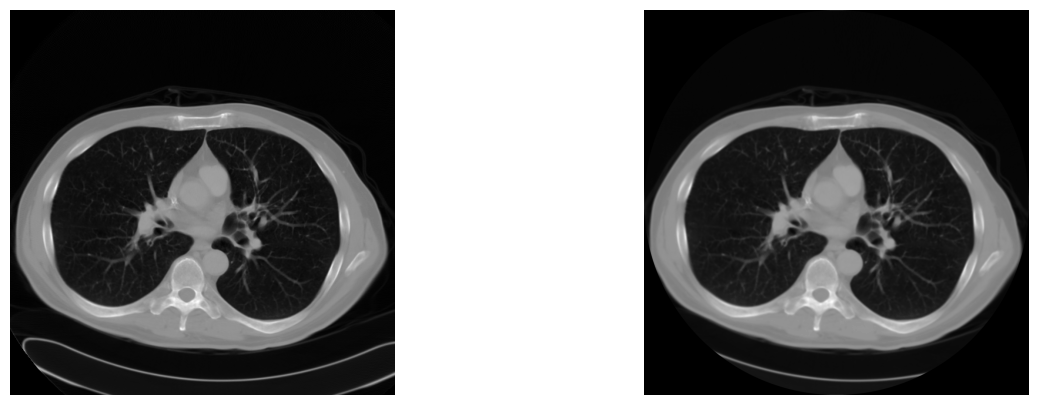

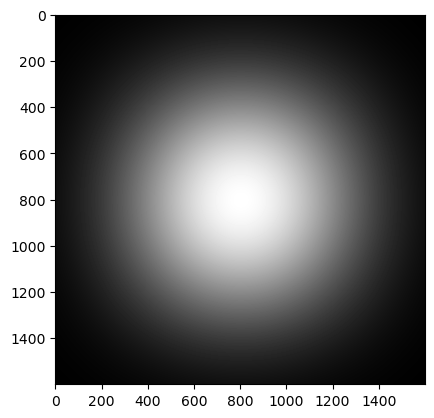

In [3]:
import astra 

N_side = 3000
N_basis = 1600
XX, YY = np.meshgrid(np.linspace(-1.5, 1.5, N_basis), np.linspace(-1.5, 1.5, N_basis))
YY = np.flip(YY, axis=0)
pixelsize = 3/N_basis

spline_basis1 = np.zeros((N_basis, N_basis))
spline_basis1 = np.where(np.abs(YY)<pixelsize, 1, 0)
spline_basis1 = np.where(XX<1/2, spline_basis1, 0)
spline_basis1 = np.where(XX>-1/2, spline_basis1, 0)

spline_basis2 = np.zeros((N_basis, N_basis))
spline_basis2 = np.where(np.abs(XX)<pixelsize, 1, 0)
spline_basis2 = np.where(YY<1/2, spline_basis2, 0)
spline_basis2 = np.where(YY>-1/2, spline_basis2, 0)

spline_basis3 = np.zeros((N_basis, N_basis))
spline_basis3 = np.where(np.abs(XX-YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis3 = np.where(XX < 1/2, spline_basis3, 0)
spline_basis3 = np.where((XX) > -1/2, spline_basis3, 0)

spline_basis4 = np.zeros((N_basis, N_basis))
spline_basis4 = np.where(np.abs(XX+YY)<np.sqrt(2)*pixelsize, 1, 0)
spline_basis4 = np.where(XX < 1/2, spline_basis4, 0)
spline_basis4 = np.where((XX) > -1/2, spline_basis4, 0)

spline_basis_0 = fftconvolve(spline_basis1, spline_basis2, mode='same')
spline_basis_1 = fftconvolve(spline_basis_0, spline_basis3, mode='same')
spline_basis_2 = fftconvolve(spline_basis_1, spline_basis4, mode='same')
final_size = N_side
#spline_basis_1 = np.flip(spline_basis_1, axis=0)

#random_phantom = np.random.randn(50, 50)
from skimage import io

image_path = "true.tiff"
# Open the TIFF image
random_phantom = io.imread(image_path)[12:512, :500]
oversampling = 500
factor = final_size//oversampling

spline_basis_3 = fftconvolve(spline_basis_0, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same')
spline_basis_3 = fftconvolve(spline_basis_3, spline_basis_0, mode='same') #comment

spline_basis = resize(spline_basis_3, (3*factor, 3*factor), anti_aliasing=False)
full_im_spline = np.zeros((final_size, final_size))
for i in range(oversampling):
    for j in range(oversampling):
        full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = random_phantom[i, j]

phantom = fftconvolve(full_im_spline, spline_basis, mode='same')
#circle mask with zeros outside
XX, YY = np.meshgrid(np.linspace(-1, 1, final_size), np.linspace(-1, 1, final_size))
mask = np.sqrt(XX**2 + YY**2) < 1
phantom = (phantom - np.min(phantom))/(np.max(phantom) - np.min(phantom))
phantom = phantom*mask
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(random_phantom, cmap='gray')
ax[1].imshow(phantom, cmap='gray')
for a in ax:
    a.axis('off')
plt.show()
phantom = cp.array(phantom)/np.max(phantom)
plt.figure()
plt.imshow(spline_basis_3, cmap='gray')
plt.show()

#phantom = create_phantom(N_side, "gaussian")
phantom /= cp.max(phantom)

def run_xp(N_angle, N_offset, oversampling, phantom):
    
    arg_shape = phantom.shape

    pitch_op = (1.,1.) 

    angles = np.linspace(0, 2*np.pi, N_angle, endpoint=False)
    vol_geom = astra.create_vol_geom(phantom.shape[0], phantom.shape[1])
    det_spacing = 1.5*N_side/N_offset
    proj_geom = astra.create_proj_geom('fanflat', det_spacing, N_offset, angles, 6000, 1500)#source_origin, origin_det
    proj_id = astra.create_projector('line_fanflat', proj_geom, vol_geom)
    sinogram_id, y_data_astra = astra.create_sino(np.array(phantom.get()), proj_id)
    y_data = cp.array(y_data_astra).reshape(-1) #+ 1*cp.random.randn(N_angle*N_offset)

    #y_data_astra = op_splines_2.apply(phantom.reshape(-1)).reshape((N_angle, N_offset)).get()
    
    ####### rec astra ########
    
    proj_geom = astra.create_proj_geom('fanflat', 1.5/(N_offset/oversampling) , N_offset, angles, 6000*oversampling/N_side, 1500*oversampling/N_side)#source_origin, origin_det
    vol_geom  = astra.create_vol_geom(oversampling,oversampling)

    proj_id = astra.create_projector('cuda', proj_geom, vol_geom)
    sino_id   = astra.data2d.create('-sino', proj_geom, y_data_astra)
    rec_id    = astra.data2d.create('-vol', vol_geom)

    cfg       = astra.astra_dict('CGLS_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId']      = sino_id
    cfg['ProjectorId']          = proj_id

    alg_id    = astra.algorithm.create(cfg)
    astra.algorithm.run(alg_id, 30)
    rec_astra              = astra.data2d.get(rec_id)
    ############################


    stop_crit = pxst.MaxIter(30)
    
    pitch_op = (phantom.shape[0]/oversampling, phantom.shape[0]/oversampling)
    arg_shape = (oversampling, oversampling)
    op_pixels, op_splines_1, op_splines_2 = set_operators_fan_beam(N_side, N_angle, N_offset, pitch_op, arg_shape, 6000, 7500) #sod sdd

    recon_pixels = op_pixels.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_1 = op_splines_1.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))
    recon_box_2 = op_splines_2.pinv(y_data, damp=0.1, kwargs_fit=dict(stop_crit=stop_crit)).reshape((oversampling, oversampling))

    factor = final_size//oversampling


    rec_pix = recon_pixels.get()
    spline_basis = resize(spline_basis_0, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_pix = np.zeros((final_size, final_size))

    for i in range(oversampling):
        for j in range(oversampling):
            full_im_pix[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_pix[i, j]

    full_im_pix = fftconvolve(full_im_pix, spline_basis, mode='same')

    #for astra, use pixels also
    full_im_astra = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_astra[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_astra[i, j]

    full_im_astra = fftconvolve(full_im_astra, spline_basis, mode='same')

    rec_spline = recon_box_1.get()
    spline_basis = resize(spline_basis_1, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline1 = fftconvolve(full_im_spline, spline_basis, mode='same')

    rec_spline = recon_box_2.get()
    spline_basis = resize(spline_basis_2, (3*factor, 3*factor), mode='reflect', anti_aliasing=False)
    full_im_spline = np.zeros((final_size, final_size))
    for i in range(oversampling):
        for j in range(oversampling):
            full_im_spline[factor*i + (factor-1)//2, factor*j + (factor-1)//2] = rec_spline[i, j]

    full_im_spline2 = fftconvolve(full_im_spline, spline_basis, mode='same')

    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    ax[0].imshow(full_im_pix, cmap='gray')
    ax[1].imshow(full_im_spline1, cmap='gray')
    ax[2].imshow(full_im_spline2, cmap='gray')
    ax[3].imshow(full_im_astra, cmap='gray')
    
    for a in ax:
        a.axis('off')
    #plt.savefig('upsampled.eps', format='eps')

    loss1 = psnr(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix))
    loss2 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1))
    loss3 = psnr(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2))
    loss4 = psnr(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra))

    ssim1 = ssim(phantom.get()/np.max(phantom.get()), full_im_pix/np.max(full_im_pix), data_range=2)
    ssim2 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline1/np.max(full_im_spline1), data_range=2)
    ssim3 = ssim(phantom.get()/np.max(phantom.get()), full_im_spline2/np.max(full_im_spline2), data_range=2)
    ssim4 = ssim(phantom.get()/np.max(phantom.get()), full_im_astra/np.max(full_im_astra), data_range=2)
    
    plt.show()
    
    return loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4


Oversampling :  20


/home/haouchat/miniconda3/envs/pyxu/lib/python3.11/site-packages/pyxu/experimental/xray/_rt.py:208: PrecisionWarning: Only Width.SINGLE-precision inputs are supported: casting.
  warnings.warn(msg, pxw.PrecisionWarning)
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.310925] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.513249] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.525431] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.537340] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.549094] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.560675] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.572669] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24.584539] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_p6xfmwli:[2025-03-17 13:01:24

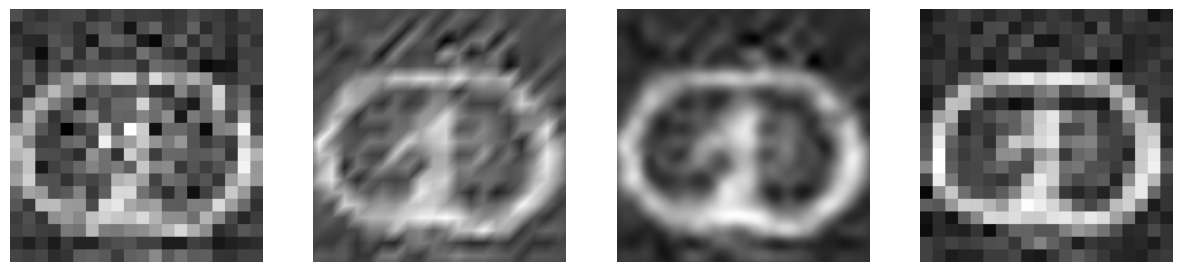

Losses :  13.864389414146077 16.668640929320283 16.24857086147342 15.363713700235857
SSIM :  0.4142256784231309 0.5336075304229738 0.6070790825794663 0.45486649460852235
Oversampling :  40


INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.585503] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.609828] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.621763] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.633464] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.645235] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.657088] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.668966] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.680503] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.692181] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.703792] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_rko647a8:[2025-03-17 13:01:39.715843] Iteration 10
	iteration: 1

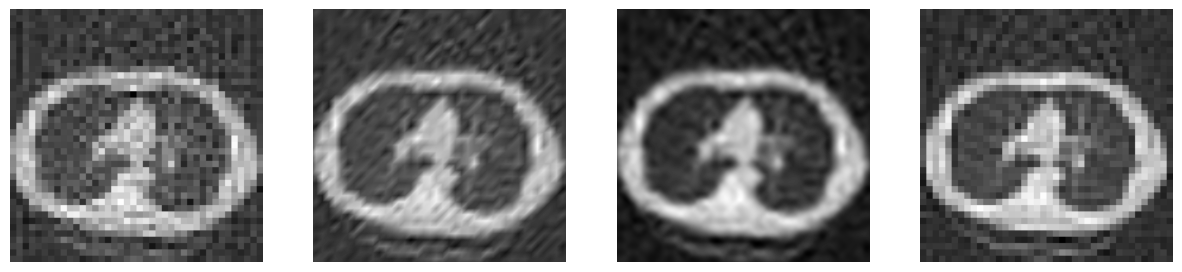

Losses :  17.210182053846932 19.44033711997157 18.264606677271008 18.33636273284186
SSIM :  0.5231073766917782 0.6522761284568759 0.701805369055907 0.5952274623182434
Oversampling :  50


INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.293328] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.313312] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.325286] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.337495] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.349507] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.361990] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.373976] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.385965] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.397695] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.409727] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_m_325_wr:[2025-03-17 13:01:53.421737] Iteration 10
	iteration: 1

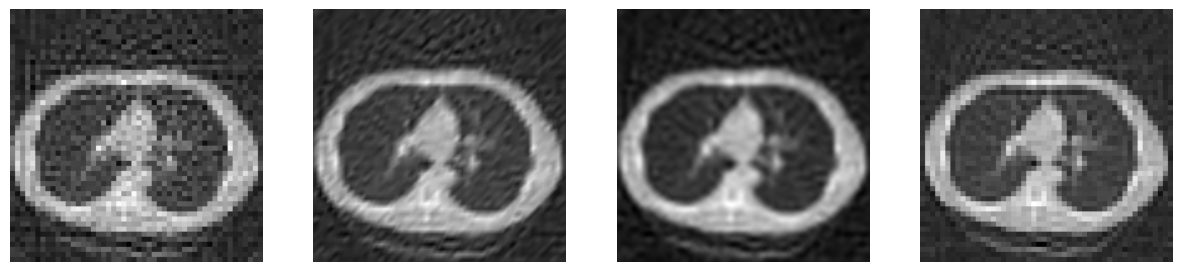

Losses :  18.291450489567428 21.124273051240422 20.361318691077127 20.780459204812047
SSIM :  0.5411962040284201 0.6965197483153762 0.7482850552942055 0.6553951748265693
Oversampling :  75


INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.340700] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.362127] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.374007] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.386159] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.398439] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.411771] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.423612] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.436243] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.448167] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.460826] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_wea2face:[2025-03-17 13:02:07.472718] Iteration 10
	iteration: 1

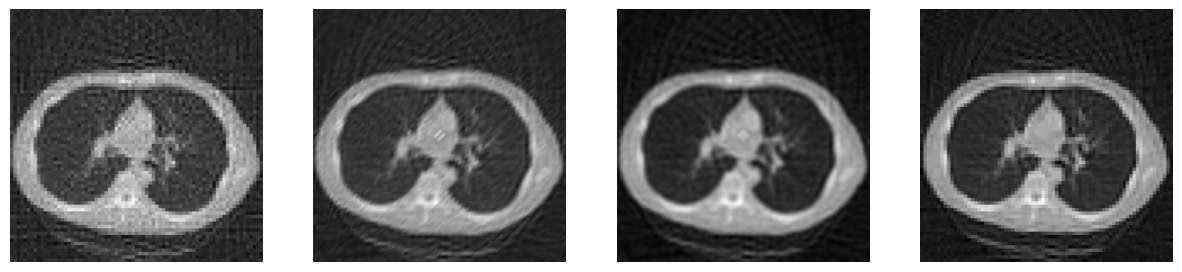

Losses :  21.154318777920622 24.108765560699705 23.746613359684808 24.033557416289256
SSIM :  0.6321047902538793 0.7818194378399382 0.8276610662730929 0.7328095452565706
Oversampling :  100


INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.749012] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.770194] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.782429] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.794098] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.805798] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.821189] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.832796] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.844183] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.856411] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.868093] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_l_7785cy:[2025-03-17 13:02:21.879835] Iteration 10
	iteration: 1

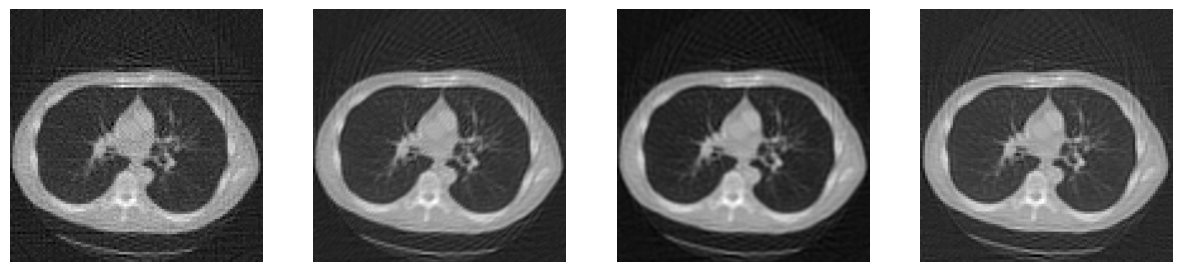

Losses :  23.20800784003799 25.797726084711666 25.879285537060582 25.647858937789888
SSIM :  0.7095590235593988 0.84357629319071 0.8830571366740704 0.7856777732514054
Oversampling :  120


INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.735185] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.756983] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.768976] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.780777] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.792784] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.804533] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.816396] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.828131] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.839794] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.851692] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_c9g7oicl:[2025-03-17 13:02:36.863725] Iteration 10
	iteration: 1

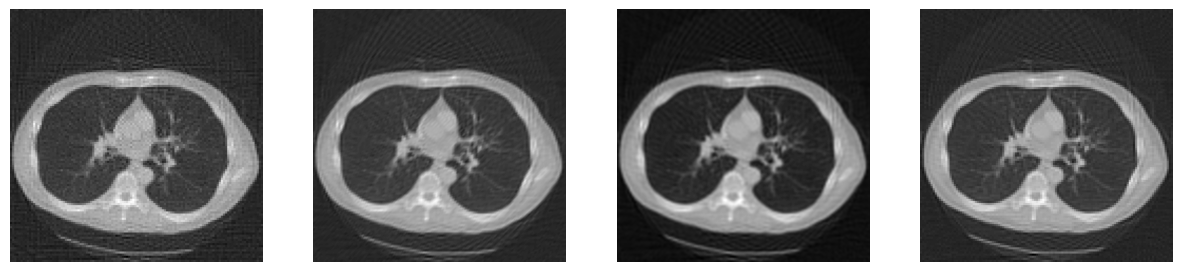

Losses :  24.221026891643724 26.83303759559807 26.316826170376192 27.036122309025025
SSIM :  0.7514550021968036 0.8735085532159654 0.90441740337166 0.8301811502951941
Oversampling :  150


INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.537501] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.557809] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.569498] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.581280] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.593113] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.604914] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.616739] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.628475] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.640302] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.651974] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu__3c_lral:[2025-03-17 13:02:52.664274] Iteration 10
	iteration: 1

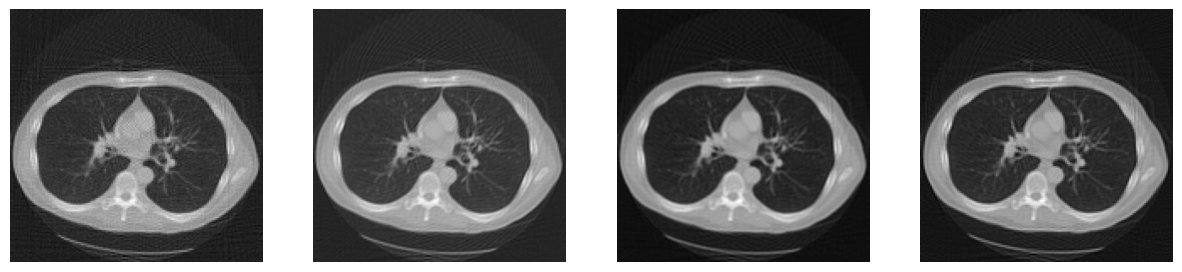

Losses :  26.004423897755053 28.272511713479776 28.373764766106163 28.715968220368442
SSIM :  0.8058361548571802 0.9080282033928937 0.9353126564260551 0.8694551265846018
Oversampling :  200


INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.717966] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.737973] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.749948] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.761675] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.773418] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.785152] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.796774] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.808455] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.820194] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.831963] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_jem1d8h5:[2025-03-17 13:03:09.843812] Iteration 10
	iteration: 1

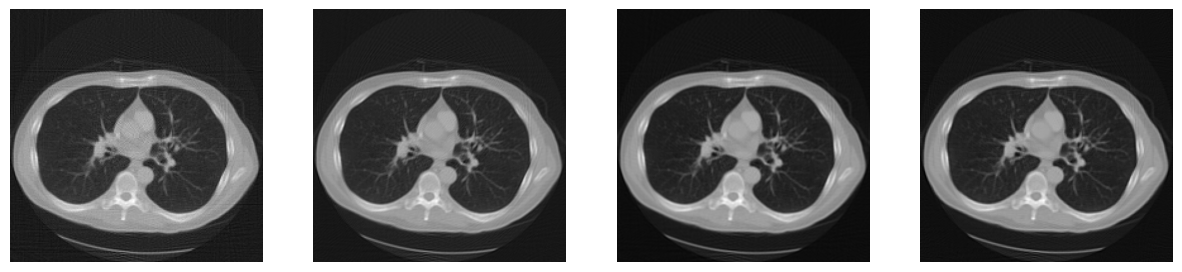

Losses :  27.794443148330732 30.873400659525252 30.839240812528107 31.33113743391497
SSIM :  0.855312813743707 0.9412591289221002 0.9577160009461742 0.9219586985642688
Oversampling :  250


INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.920031] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.941389] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.953525] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.965368] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.977650] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:28.990256] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:29.002120] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:29.014249] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:29.026386] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:29.038827] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_eb_j5e0x:[2025-03-17 13:03:29.051275] Iteration 10
	iteration: 1

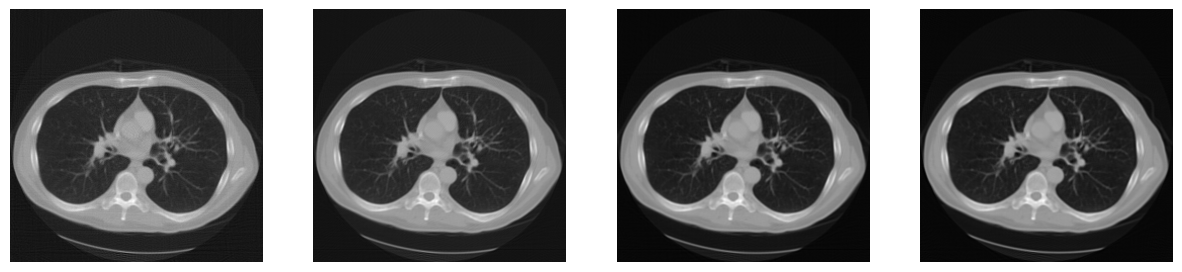

Losses :  29.77930945733176 32.63747157179366 32.75987661649431 33.32711327831944
SSIM :  0.8926102932869412 0.9609564855692249 0.9711746370247556 0.946711376671494
Oversampling :  300


INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.409814] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.430257] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.442971] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.455757] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.468494] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.481129] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.493759] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.506284] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.518850] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.531240] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_bwbod1k7:[2025-03-17 13:03:51.543886] Iteration 10
	iteration: 1

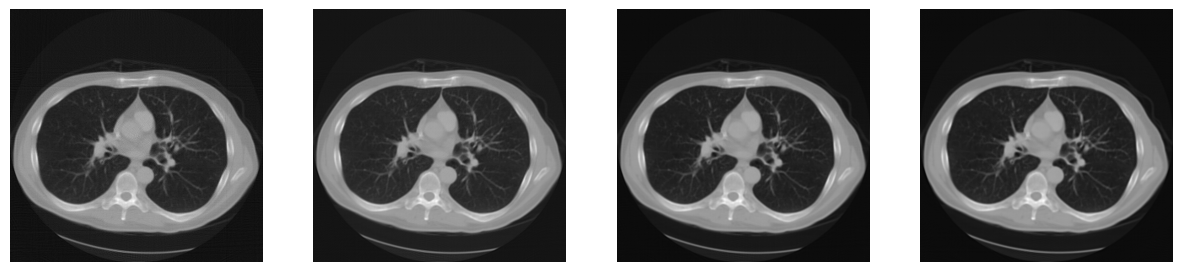

Losses :  31.314942505929203 34.158386791380124 34.1767727434319 34.72344450785244
SSIM :  0.9115596985235852 0.9706586415439353 0.9770442305011653 0.9582704438495651
Oversampling :  375


INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.275311] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.300159] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.314752] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.329192] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.343558] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.357915] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.372635] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.386883] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.401177] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.415659] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_yeue4lm2:[2025-03-17 13:04:17.429832] Iteration 10
	iteration: 1

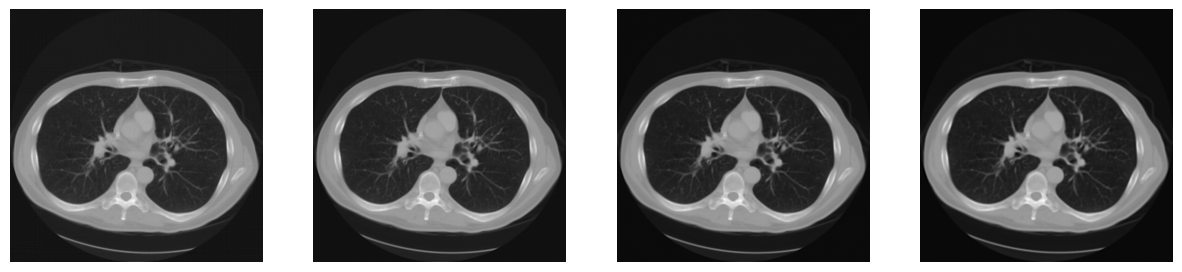

Losses :  32.92455272145043 35.85640597152007 35.87778070794998 36.396419209042634
SSIM :  0.9300879621084654 0.9773112347396736 0.9812406372722943 0.9677647694645571
Oversampling :  500


INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.401901] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.430839] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.449127] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.467259] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.485584] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.503778] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.521915] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.540241] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.558502] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.576714] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_gs5jkpuw:[2025-03-17 13:04:51.594952] Iteration 10
	iteration: 1

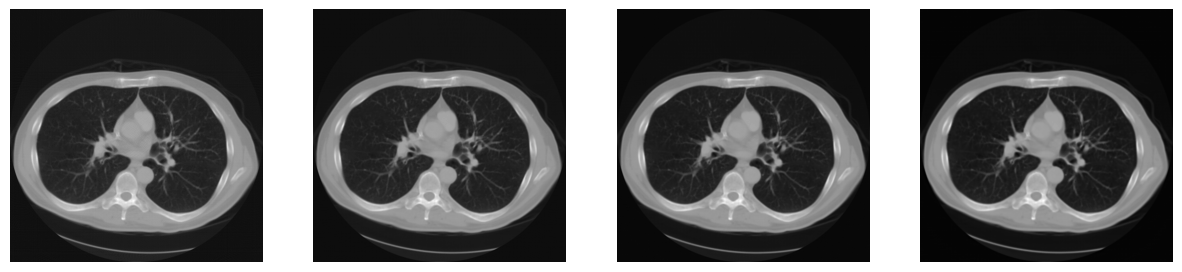

Losses :  34.899098135134636 37.92579774245301 37.86193429826687 38.513460590734525
SSIM :  0.9511678905114325 0.9840146577181701 0.9857525174658881 0.9800600023621928
Oversampling :  1000


INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:08.977935] Iteration 0
	iteration: 0
	N_iter: 1.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.051297] Iteration 1
	iteration: 1
	N_iter: 2.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.117095] Iteration 2
	iteration: 2
	N_iter: 3.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.182823] Iteration 3
	iteration: 3
	N_iter: 4.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.247454] Iteration 4
	iteration: 4
	N_iter: 5.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.312562] Iteration 5
	iteration: 5
	N_iter: 6.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.377788] Iteration 6
	iteration: 6
	N_iter: 7.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.442605] Iteration 7
	iteration: 7
	N_iter: 8.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.507512] Iteration 8
	iteration: 8
	N_iter: 9.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.572220] Iteration 9
	iteration: 9
	N_iter: 10.0
INFO:/tmp/pyxu_sorshjur:[2025-03-17 13:06:09.636978] Iteration 10
	iteration: 1

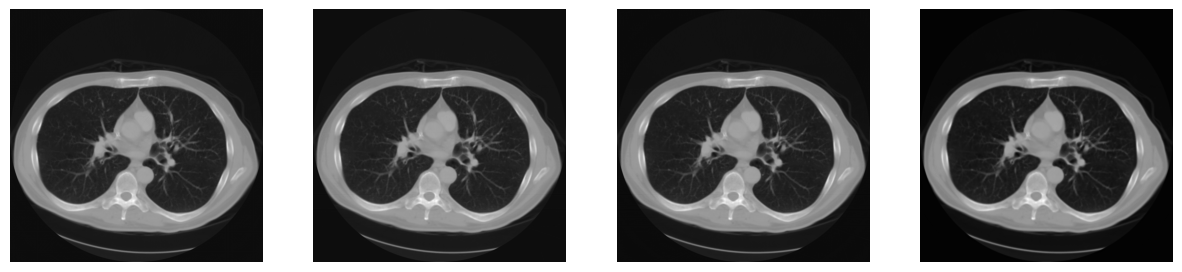

Losses :  38.73615250405023 41.102602739411054 41.284826595816064 41.54200576427116
SSIM :  0.9745589922377236 0.9874840034443191 0.9887201595984172 0.9888040819335547


In [4]:
oversamplings =[20, 40, 50, 75, 100, 120, 150, 200, 250, 300, 375, 500, 1000]

losses1 = []
losses2 = []
losses3 = []
losses4 = []

ssims1 = []
ssims2 = []
ssims3 = []
ssims4 = []

images_pix = []
images_spline1 = []
images_spline2 = []
images_astra = []

for oversampling in oversamplings:
    print('Oversampling : ', oversampling)
    loss1, loss2, loss3, loss4, full_im_pix, full_im_spline1, full_im_spline2, full_im_astra, ssim1, ssim2, ssim3, ssim4 = run_xp(int(2*oversampling), int(1*oversampling), oversampling, phantom)
    losses1.append(loss1)
    losses2.append(loss2)
    losses3.append(loss3)
    losses4.append(loss4)
    ssims1.append(ssim1)
    ssims2.append(ssim2)
    ssims3.append(ssim3)
    ssims4.append(ssim4)


    images_pix.append(full_im_pix)
    images_spline1.append(full_im_spline1)
    images_spline2.append(full_im_spline2)
    images_astra.append(full_im_astra)
    
    print('Losses : ', loss1, loss2, loss3, loss4)
    print('SSIM : ', ssim1, ssim2, ssim3, ssim4)

In [5]:
#save everything
np.save('oversamplings.npy', oversamplings)
np.save('losses1_cone.npy', losses1)
np.save('losses2_cone.npy', losses2)
np.save('losses3_cone.npy', losses3)
np.save('losses4_cone.npy', losses4)
np.save('ssims1_cone.npy', ssims1)
np.save('ssims2_cone.npy', ssims2)
np.save('ssims3_cone.npy', ssims3)
np.save('ssims4_cone.npy', ssims4)
'''
np.save('images_pix.npy', images_pix)
np.save('images_spline1.npy', images_spline1)
np.save('images_spline2.npy', images_spline2)
np.save('images_astra.npy', images_astra)'''

"\nnp.save('images_pix.npy', images_pix)\nnp.save('images_spline1.npy', images_spline1)\nnp.save('images_spline2.npy', images_spline2)\nnp.save('images_astra.npy', images_astra)"

In [6]:
#load everything
oversamplings = np.load('oversamplings.npy')
losses1 = np.load('losses1.npy')
losses2 = np.load('losses2.npy')
losses3 = np.load('losses3.npy')
losses4 = np.load('losses4.npy')
ssims1 = np.load('ssims1.npy')
ssims2 = np.load('ssims2.npy')
ssims3 = np.load('ssims3.npy')
ssims4 = np.load('ssims4.npy')
images_pix = np.load('images_pix.npy')
images_spline1 = np.load('images_spline1.npy')
images_spline2 = np.load('images_spline2.npy')
images_astra = np.load('images_astra.npy')

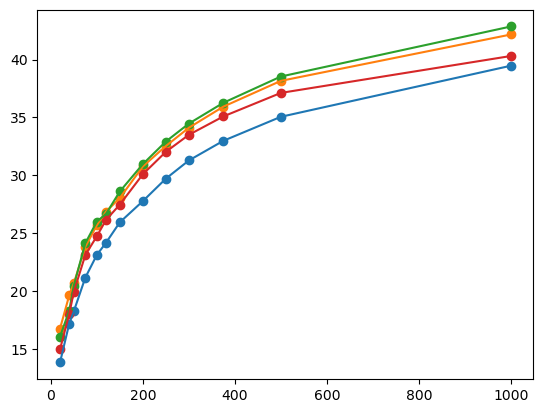

In [6]:

plt.figure('Losses')
plt.plot(oversamplings, losses1, label='Pixels psnr')
plt.plot(oversamplings, losses2, label='Box-splines 1 psnr')
plt.plot(oversamplings, losses3, label='Box-splines 2 psnr')
plt.plot(oversamplings, losses4, label='Astra psnr')

plt.scatter(oversamplings, losses1)
plt.scatter(oversamplings, losses2)
plt.scatter(oversamplings, losses3)
plt.scatter(oversamplings, losses4)
# max of y is 40
#plt.legend()
plt.show()

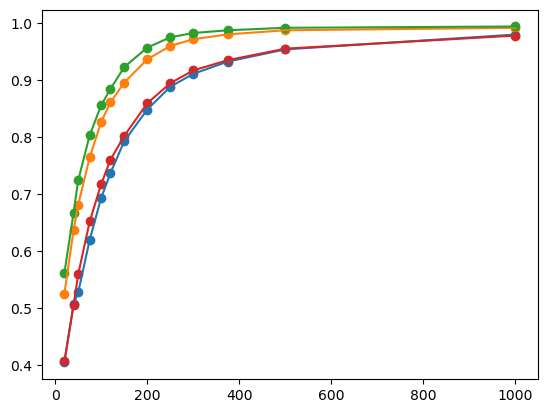

In [7]:
plt.figure('SSIM')
plt.plot(oversamplings, ssims1, label='Pixels ssim')
plt.plot(oversamplings, ssims2, label='Box-splines 1 ssim')
plt.plot(oversamplings, ssims3, label='Box-splines 2 ssim')
plt.plot(oversamplings, ssims4, label='Astra ssim')

plt.scatter(oversamplings, ssims1)
plt.scatter(oversamplings, ssims2)
plt.scatter(oversamplings, ssims3)
plt.scatter(oversamplings, ssims4)

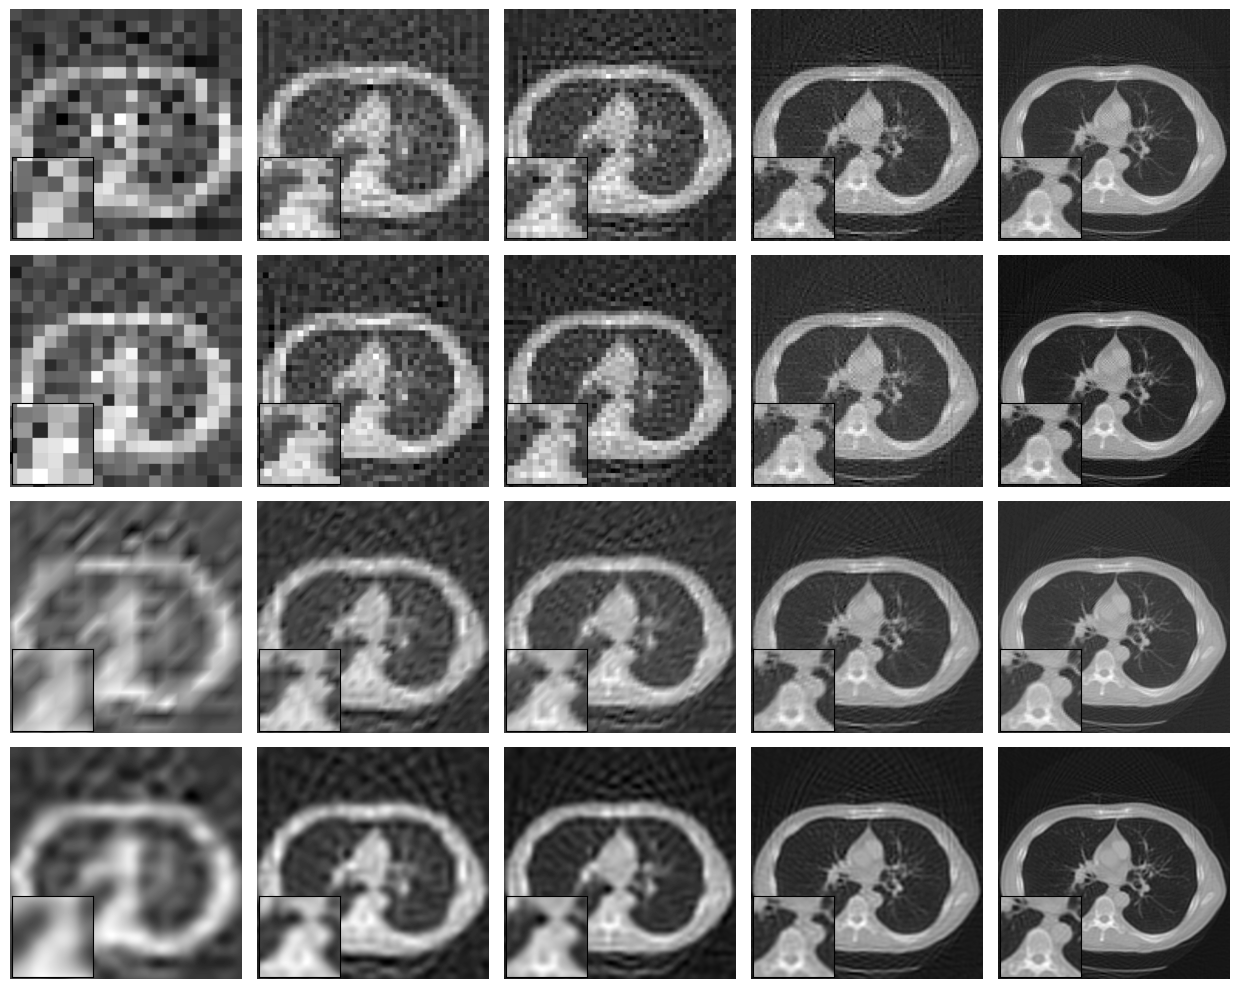

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Create figure and subplots
fig, ax = plt.subplots(4, 5, figsize=(10*5/4, 10))
k = 0

# Define the zoom-in region (adjust these values based on your images)
x1, x2, y1, y2 = 1000, 1800, 600, 1400  # Example: Region to zoom into

for i in range(len(oversamplings)):
    if i in [0, 1, 2, 4, 6]:#, 12]:  # Select specific oversampling values
        images = [images_pix[i], images_astra[i], images_spline1[i], images_spline2[i]]
        
        for row in range(4):
            # Display main image
            ax[row, k].imshow(images[row], cmap='gray')
            ax[row, k].axis('off')

            # Add inset for zoomed-in view
            axins = ax[row, k].inset_axes([0.01, 0.01, 0.35, 0.35])  # (x, y, width, height)
            #remove ticks
            axins.set_xticks([])
            axins.set_yticks([])

            # Display zoomed-in region
            axins.imshow(images[row], cmap='gray', extent=[0, images[row].shape[1], 0, images[row].shape[0]])

            # Define zoom region
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins

        k += 1

        #tight layout
plt.tight_layout()
plt.savefig('table_img2_cone.eps', format='eps')
plt.show()
